# Double Q-Learning
## Using TF-2 Keras
## Using Experience Replay

### Tested on Pong

In [1]:
import gym
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess game image!

In [2]:
from gym.core import ObservationWrapper, Wrapper
from gym.spaces import Box

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64,64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))
        
    def observation(self, img):
        
        img = img[30:-10,:,:].astype('float32')
        img = cv2.resize(img/255.,self.img_size, interpolation=cv2.INTER_LINEAR)
        img = img.mean(-1, keepdims=True)
        return img

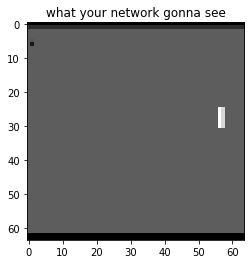

In [3]:
#Start the environment
env = gym.make("PongNoFrameskip-v4")
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

plt.title("what your network gonna see")
plt.imshow(obs, interpolation='none', cmap='gray')

### Framebuffer

In [4]:
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

In [5]:
def make_env():
    env = gym.make("PongNoFrameskip-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
print("n_actions", n_actions)
state_dim = env.observation_space.shape
print("state_dim", state_dim)
print("Action names:", env.env.env.get_action_meanings())

n_actions 6
state_dim (64, 64, 4)
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


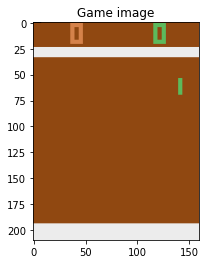

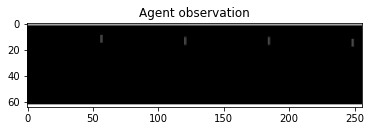

In [6]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.title("Agent observation")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]), cmap='gray')

## TF Stuff

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Create our DNN model

In [9]:
class OurDNN(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(OurDNN, self).__init__()
        #Input layer
        self.inp = L.InputLayer(input_dim)
#       #Hidden layers
        self.hd1 = L.Conv2D(32, kernel_size=4, strides=4, activation='relu')
        self.hd2 = L.Conv2D(64, kernel_size=4, strides=2, activation='relu')
        self.hd3 = L.Conv2D(64, kernel_size=3, strides=2, activation='relu')
        self.fl1 = L.Flatten()
        self.hd4 = L.Dense(128, activation='relu')
        #Output
        self.out = L.Dense(output_dim, activation='linear')
        
    @tf.function
    def call(self, input_data):
        #Essentially feedforward your network
        inp_fwd = self.inp(input_data)
        x_fwd = self.hd1(inp_fwd)
        x_fwd = self.hd2(x_fwd)
        x_fwd = self.hd3(x_fwd)
        x_fwd = self.fl1(x_fwd)
        x_fwd = self.hd4(x_fwd)
        out_fwd = self.out(x_fwd)
        #Get the output
        return out_fwd        

## Create our AQL Agent

### The loss function for our agent is defined as - 
$$ L(w) = { 1 \over N} \sum_i (Q(s,a,w) - [r(s,a) + \gamma \cdot Q^{old}(s', argmax_{a^*}Q(s', a^*))]) ^2 $$

Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

### The update equation is defined as
$$ \textbf{w} \leftarrow \textbf{w} + \alpha*\nabla_{\textbf w}L(\textbf w)$$

### Here we have two identical neural networks!
#### 1.Current Q-network which will be used to calculate $Q(s,a)$
#### 2. Old snapshot of the network will be used to calculate  $Q^{old}(s',a)$
Where $a$ is $argmax_{a^*}Q(s', a^*)$

This target network is updated at very target_steps time steps using the params of the Q-network - Hard Copy method

Solves the problem of maximization bias

In [10]:
class OurAgent:
    def __init__(self, env, alpha=1e-4, epsilon=0.5, gamma=0.99, buffer_size=5*10**4, load=False):
        #Set up constants
        self.state_dim = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        self.optimizer = keras.optimizers.Adam(alpha)
        self.buffer = ReplayBuffer(buffer_size)
        
        if load:
            self.network = keras.models.load_model("./models/DoQN-pong")
            self.snap_network = keras.models.load_model("./models/DoQN-pong")
            self.network.summary()
            print("Loaded old model")
        else:
            #Create model
            self.network = OurDNN(self.state_dim, self.n_actions)
            self.network.compile(self.optimizer)
            #Create snapshot
            self.snap_network = OurDNN(self.state_dim, self.n_actions)
            self.snap_network.compile(self.optimizer)
            self.snapshot_weights()
            print("Created new model")
        
    def snapshot_weights(self):
        '''
        Take a snapshot of the main network weights
        '''
        self.snap_network.set_weights(self.network.get_weights())
    
    def get_action(self, state):
        '''
        Use E-greedy policy to get the agent action
        '''
        #Approximate the q_values
        q_values = self.network(state[None])[0]
        #Explore or exploit
        ore_or_oit = np.random.choice([0,1], p =[self.epsilon, 1-self.epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_action = np.random.choice(self.n_actions, 1)[0] #Over uniform dist
        #If wanna exploit
        else:
            chosen_action = np.argmax(q_values)
            
        return chosen_action
        
    def get_loss(self, state, action, reward, next_state, is_done):
        '''
        Get the loss function defined above
        '''
        #Get 𝑄(s,a) using our Q network model
        pred_q = self.network(state.astype('float32'))
        pred_q_for_a = tf.reduce_sum(pred_q * tf.one_hot(action, self.n_actions), axis=1)
        
        #Get Q(s',a') using our Q network model
        pred_next_q = self.network(next_state.astype('float32'))
        #Get the optimal action a* from Q(s',a')
        opt_act = tf.math.argmax(pred_next_q, axis=1).numpy()[0]
        #Get Q_old(s',a') using the snapshot model
        pred_q_old = self.snap_network(np.atleast_2d(next_state.astype('float32')))
        #Get Q_old(s',a*)
        pred_q_old = pred_q_old[:,opt_act]
        
        #Get target Q-value, Q_(s',a')
        target_q_for_a = reward + self.gamma*pred_q_old
        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_q_for_a = tf.where(is_done, reward, target_q_for_a)
        
        #Calculate loss
        #Stop gradient is not required since we only update Q-net
        loss = (pred_q_for_a - target_q_for_a) ** 2
        loss = tf.reduce_mean(loss)
        
        return loss
    
    def train_step(self, state, action, reward, next_state, is_done):
        '''
        Trains the network
        '''
        #Variables to train - here weight
        variables = self.network.trainable_variables
        
        #Perform semi-grad Q Learning with Adam optimizer
        with tf.GradientTape() as tape:
            loss = self.get_loss(state, action, reward, next_state, is_done)
            gradients = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(gradients, variables))
        
        return loss
    
    def save(self):
        print("Saving model")
        self.network.save("./models/DoQN-pong", save_format="tf")

## Create experience replay buffer

In [11]:
import random

#Saves data in uint8 format and returns in float32
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        #Convert to uint8 to save memory
        obs_t = (obs_t*255).astype(np.uint8)
        obs_tp1 = (obs_tp1*255).astype(np.uint8)

        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            #Reconvert data to float
            obs_t = obs_t.astype(np.float32)/255
            obs_tp1 = obs_tp1.astype(np.float32)/255
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)


## Session generator+recorder

In [12]:
def generate_record(agent, n_steps = 1):
    '''
    Play the game for n steps, record to buffer and return rewards
    '''
    s = agent.env.framebuffer
    reward = 0
    
    for i in range(n_steps):
        a = agent.get_action(s)
        next_s, r, done, _ = agent.env.step(a)
        #Store data
        data = [s,a,r,next_s,done]
        agent.buffer.add(*data)
        #Update
        s = next_s
        reward += r
        #Reset if done
        if done:
            s = agent.env.reset()
    return reward

## Evaluate agent in games

In [13]:
def evaluate(agent, n_games=1, t_max=10**4):
    '''
    Will play n full games and returns mean rewards
    '''
    rewards = []
    for _ in range(n_games):
        s = agent.env.reset()
        reward = 0
        for _ in range(t_max):
            a = agent.get_action(s)
            s, r, done, _ = agent.env.step(a)
            reward += r
            if done: break
        rewards.append(reward)
    return np.mean(rewards)

## Train

In [22]:
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def moving_average(x, span=100, **kw):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values

reward_history = []
loss_history = []
max_reward = -100

In [23]:
#The agent 
agent = OurAgent(env)

Created new model


In [20]:
#Initial data for buffer
generate_record(agent, n_steps = 100)
print(len(agent.buffer))

100


In [21]:
agent.save()

Saving model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/DoQN-pong/assets


STOPPED
Buffer size = 50000, Epsilon = 0.01624
Mean reward:  -19.666666666666668


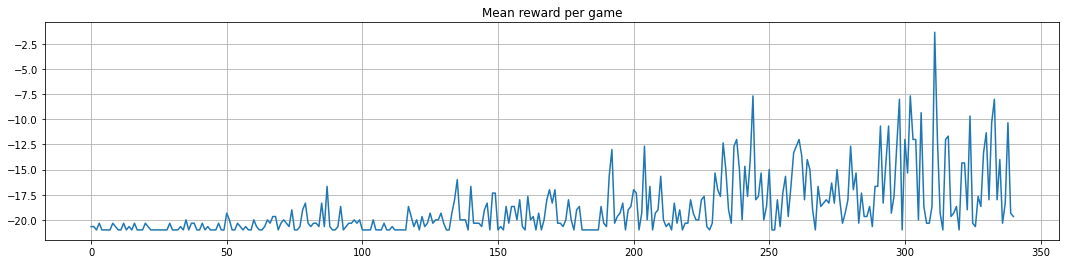

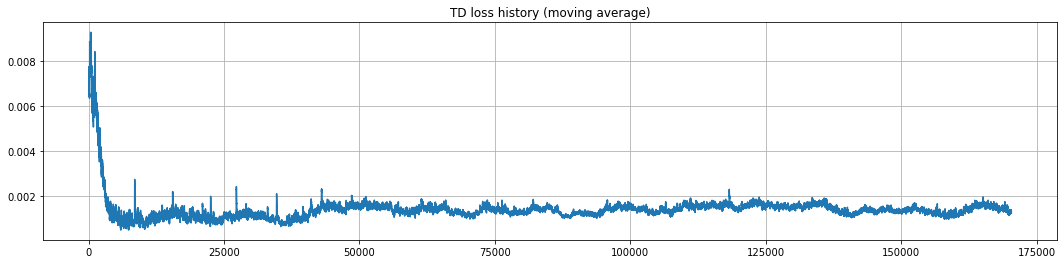

In [23]:
try:
    for i in trange(10**6):
        #Generate samples
        generate_record(agent, n_steps=10)
        #Get samples
        samples = agent.buffer.sample(batch_size=256)
        #Train
        curr_loss = agent.train_step(*samples)
        loss_history.append(curr_loss)
        
        #Adjust params
        if i%500 == 0:
            #Update snapshot model
            agent.snapshot_weights()
            #Update epsilon
            agent.epsilon = max(agent.epsilon*0.99, 0.01)
            #Evaluate and get rewards
            curr_reward = evaluate(agent, n_games=3)
            reward_history.append(curr_reward)
            #If curr reward is greater than max_reward, save
            if curr_reward > max_reward:
                max_reward = curr_reward
                agent.save()
            
        #Update graphs
        if i%100 == 0:
            clear_output(True)
            print("Buffer size = %i, Epsilon = %.5f" % (len(agent.buffer), agent.epsilon))
            print("Mean reward: ", reward_history[-1])
            plt.figure(figsize=[40, 4])
            plt.subplot(1, 2, 1)
            plt.title("Mean reward per game")
            plt.plot(reward_history)
            plt.grid()
            
            plt.figure(figsize=[40, 4])
            plt.subplot(1, 2, 2)
            plt.title("TD loss history (moving average)")
            plt.plot(moving_average(np.array(loss_history), span=100, min_periods=100))
            plt.grid()
            
            plt.show()

except KeyboardInterrupt:
    clear_output(True)
    print("STOPPED")
    print("Buffer size = %i, Epsilon = %.5f" % (len(agent.buffer), agent.epsilon))
    print("Mean reward: ", reward_history[-1])
    plt.figure(figsize=[40, 4])
    plt.subplot(1, 2, 1)
    plt.title("Mean reward per game")
    plt.plot(reward_history)
    plt.grid()

    plt.figure(figsize=[40, 4])
    plt.subplot(1, 2, 2)
    plt.title("TD loss history (moving average)")
    plt.plot(moving_average(np.array(loss_history), span=100, min_periods=100))
    plt.grid()

    plt.show()

In [ ]:
agent.save()

In [24]:
agent.epslion = 0

In [27]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    agent.env = env_monitor
    sessions = [evaluate(agent, n_games=1, t_max=10**5) for _ in trange(10)]
    print(sessions)

100%|██████████| 10/10 [03:16<00:00, 19.64s/it]

[-14.0, -12.0, -12.0, -20.0, -8.0, -17.0, -12.0, -19.0, -4.0, -18.0]


In [28]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices